# Logistic Regression

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing # LabelEncoder
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy import stats #Para la moda
## Gráfica tabla
from tempfile import TemporaryDirectory

import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

In [13]:
def loadModel(name):    
    path = "../../Models/" + name + ".pkl"
    clf = joblib.load(path)
    
    return clf;

In [4]:
def saveModel(clf, name):
    path = "../../Models/" + name + ".pkl"
    joblib.dump(clf, "model.pkl") 

In [5]:
def loadCSV(pathSamples, pathMatrix):
    df_loaded = pd.read_table(pathMatrix, sep=',')
    data = pd.read_table(pathSamples, sep=',')
    clin_trial_values = df_loaded.values
    
    Y = data['Eligible']
    Y = Y.astype(int)
    X = clin_trial_values[:, :]
    return X,Y;

In [6]:
def loadHD5(name):
    path = '../../Tables/'
    path += name + '.h5'
    return pd.read_hdf(path, 'df').values

In [7]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [8]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [9]:
# F1
def model_LR_F1(C, solver, impresion=True, classifier=None):
    if classifier is None:
        LR = LogisticRegression(C=C, solver=solver, max_iter = 200)
    else:
        LR = classifier
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([5,2])
    accuracy_list_train = np.zeros([5,2])
    precision_list = np.zeros([5,2])
    precision_list_train = np.zeros([5,2])
    recall_list = np.zeros([5,2])
    recall_list_train = np.zeros([5,2])
    error = np.zeros([5,2])
    error_train = np.zeros([5,2])
    f_list = np.zeros([5,2]) 
    f1_train = np.zeros([5,2])
    
    skf = StratifiedKFold(n_splits=5)
    
    for i, indexes in enumerate(skf.split(X, Y)):
        #Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.2) # Modificar metodología de validación
        #scaler = MinMaxScaler() #Escala entre 0 y 1
        #Xtrain = scaler.fit_transform(Xtrain)
        #Xtest = scaler.transform(Xtest)
        
        Xtrain, Xtest = X[indexes[0]], X[indexes[1]]
        Ytrain, Ytest = Y[indexes[0]], Y[indexes[1]]

        if classifier is None:
            LR.fit(Xtrain, Ytrain)
        
        pred = LR.predict(Xtest)
        pred_train = LR.predict(Xtrain)
        
        # accuracy
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[i] = _accuracy_

        _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        accuracy_list_train[i] = _accuracy_train_

        # recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[i] = _recalls_
        
        _recalls_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        recall_list_train[i] = _recalls_train_

        # precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[i] = _precisions_
        
        _precisions_train_ = precision_score(Ytrain, pred_train, average=None)
        precision_list_train[i] = _precisions_train_
        
        # f1
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[i] = _f_score_
        
        _f_score_train = f1_score(Ytrain, pred_train, average=None)
        f1_train[i] = _f_score_train
          
    if impresion:    
        #Curva ROC
        LR_probs = LR.predict_proba(Xtest)
        plot_roc(Xtest, Ytest, LR_probs, "LR")

        # Matriz Confusion
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)
        
        report = {
            'f1':[np.around(np.mean(f1_train), decimals=5), np.around(np.std(f1_train), decimals=5), np.around(np.mean(f_list), decimals=5), np.around(np.std(f_list), decimals=5)],
            'accuracy':[np.around(np.mean(accuracy_list_train), decimals=5), np.around(np.std(accuracy_list_train), decimals=5), np.around(np.mean(accuracy_list), decimals=5), np.around(np.std(accuracy_list), decimals=5)],
            'precision':[np.around(np.mean(precision_list_train), decimals=5), np.around(np.std(precision_list_train), decimals=5), np.around(np.mean(precision_list), decimals=5), np.around(np.std(precision_list), decimals=5)],
            'recall':[np.around(np.mean(recall_list_train), decimals=5), np.around(np.std(recall_list_train), decimals=5), np.around(np.mean(recall_list), decimals=5), np.around(np.std(recall_list), decimals=5)]
        }

        print(pd.DataFrame.from_dict(report, orient='index', columns=['Training score', '+/-', 'Test score', '+/-']))

        print("Total time:", time.time()-tiempo_i)

    return np.mean(f1_train), np.std(f1_train), np.mean(f_list), np.std(f_list), time.time()-tiempo_i;

In [10]:
def grid_search():
    parameters = {'C':[.01,.1,.5,1,1.5,2], 'solver':['newton-cg','lbfgs','liblinear','sag','saga']}
    LR = LogisticRegression(max_iter=200)
    clf = GridSearchCV(LR, parameters, scoring='f1', n_jobs=-1, return_train_score=True)
    clf.fit(X,Y)
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = clf.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(parameters['solver']),len(parameters['C']))

    scores_sd = clf.cv_results_['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(parameters['solver']),len(parameters['C']))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize=(20, 10))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(parameters['solver']):
        ax.plot(parameters['C'], scores_mean[idx,:], '-o', label= 'solver' + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel('C', fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    return clf

In [11]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
def vc(param_name, param_range, C=1, solver='lbfgs'):
    LR = LogisticRegression(C=C, solver=solver, max_iter = 200)
    train_scores, test_scores = validation_curve(
        LR, X, Y, param_name=param_name, param_range=param_range,
        scoring="f1", n_jobs=1)
    return train_scores, test_scores;

## LSA, 10k, sin caracteres especiales, 1200 Tópicos

Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. Eliminando las 2 palabras que más aparecen y las que sólo aparecen 1-10 veces para hacer el LSA. 1200 tópicos.

In [9]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1200.csv") #Cargar SCV

In [11]:
a, b, c, d, e = model_LR_F1(.5, 'saga')

Average train F1 score: 0.8962476350170847 +/- 0.006359667601861963
Average test F1 score: 0.7407666676694319 +/- 0.003628855085921692
Average time: 11.975479304790497


In [12]:
grid_search()

{'mean_fit_time': array([27.12547688, 15.14959722, 12.53781629,  7.42543459,  7.15983176,
        18.88445611,  5.9929801 , 11.02440329, 10.43664818, 22.57444248,
        15.38205724,  6.14795575, 13.58446598, 27.06401296, 60.98003078,
         8.97181115,  4.47334132,  9.73954949, 41.30292897, 78.37038617,
        12.17084742,  5.14164729, 10.76181502, 52.06434627, 72.81863499,
         9.83429708,  4.83785968, 10.44945092, 56.02355685, 51.73643794]),
 'std_fit_time': array([0.8387592 , 5.27145206, 0.12498474, 1.58931118, 1.83127477,
        6.50649832, 1.01297276, 2.78426786, 0.70803048, 1.21256574,
        4.47906105, 0.90929115, 1.13577627, 2.1423751 , 1.12616615,
        1.15440438, 0.50030193, 0.80936823, 0.87059979, 0.93860451,
        1.14857179, 0.19858525, 0.83847869, 0.40326418, 0.6911894 ,
        0.78782763, 0.30154014, 1.40621918, 0.56069747, 9.94233389]),
 'mean_score_time': array([0.13307743, 0.44290619, 0.09414759, 0.0405251 , 0.06243591,
        0.52780147, 0.60722194

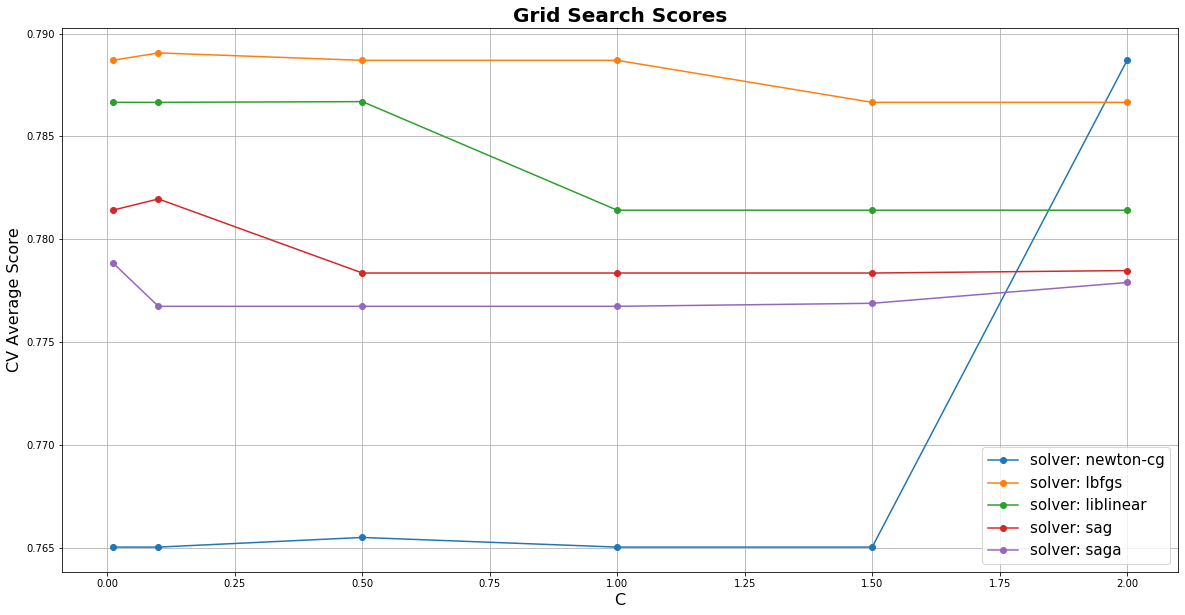

In [17]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize=(20, 10))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
c =  {'mean_test_score': np.array([0.7650413 , 0.7650413 , 0.76550984, 0.7650413 , 0.7650413 ,
        0.78870006, 0.78870006, 0.78906152, 0.78870006, 0.78870006,
        0.7866585 , 0.7866585 , 0.78665893, 0.7866585 , 0.78669421,
        0.78141536, 0.78141536, 0.78141536, 0.78141536, 0.78196255,
        0.77836274, 0.77836274, 0.77836274, 0.77848241, 0.77887113,
        0.77674469, 0.77674469, 0.77674469, 0.77689139, 0.77790247]),
 'std_test_score': np.array([0.0067881 , 0.0067881 , 0.00582972, 0.0067881 , 0.0067881 ,
        0.0102076 , 0.0102076 , 0.01006338, 0.0102076 , 0.0102076 ,
        0.01201305, 0.01201305, 0.01195956, 0.01201305, 0.01210996,
        0.01455616, 0.01455616, 0.01455616, 0.01455616, 0.01476146,
        0.01377124, 0.01377124, 0.01377124, 0.01379239, 0.01416149,
        0.01447691, 0.01447691, 0.01447691, 0.01459147, 0.0149928 ])}

plot_grid_search(c,[.01,.1,.5,1,1.5,2],['newton-cg','lbfgs','liblinear','sag','saga'],'C','solver')

In [ ]:
train_scores, test_scores = vc(param_name='C', param_range=[1,2,3,4,5,6,7,8,9])
for i, scores in enumerate(zip(train_scores, test_scores)):
    print('K:', i+1, ', F1 score train:', np.mean(scores[0]), '. Score test:', np.mean(scores[1]))

In [ ]:
## Plot LC

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (LogisticRegression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(C=0.5, solver='saga', max_iter = 200)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

# Another stimator
#title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.001)
#plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                    cv=cv, n_jobs=4)

plt.show()

## LSA, 10k, sin caracteres especiales, 1500 Tópicos

Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. 1500 tópicos.

In [29]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV

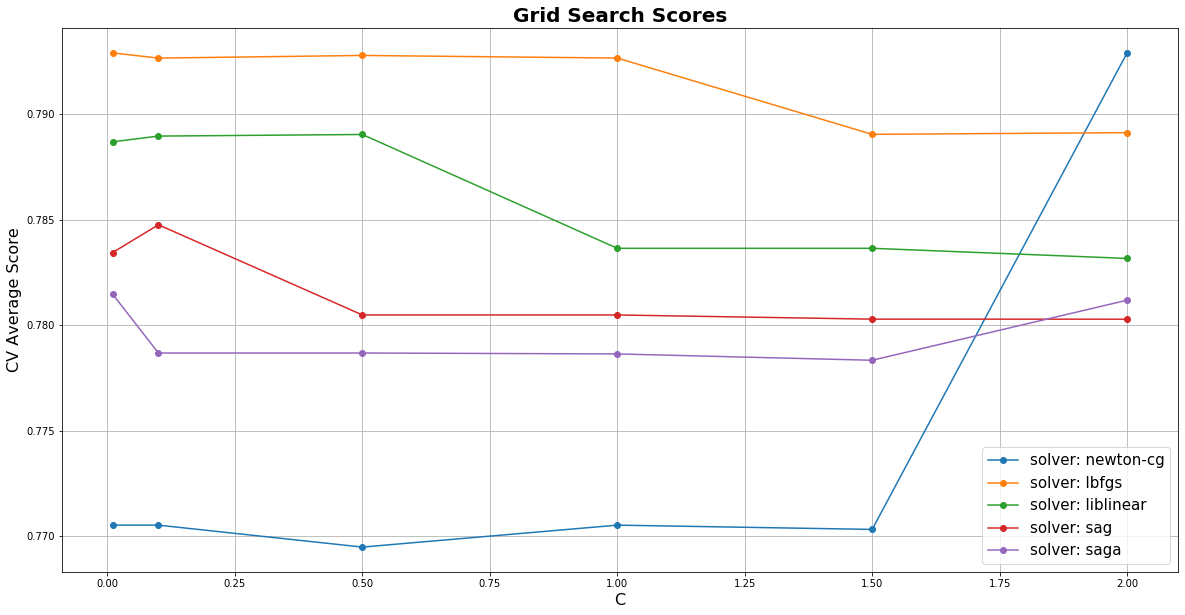

In [23]:
clf = grid_search()
saveModel(clf_rbf, "LR_LSA_1500") 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.856


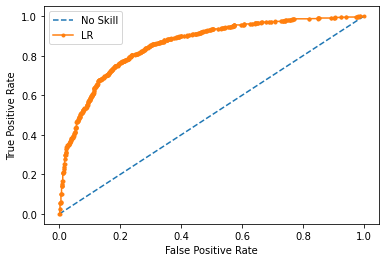

           Training score      +/-  Test score      +/-
f1                0.87285  0.00260     0.77828  0.01394
accuracy          0.87285  0.00252     0.77830  0.01379
precision         0.87288  0.00428     0.77841  0.01490
recall            0.87285  0.00252     0.77830  0.01688
Total time: 44.61213970184326


(0.8728471438804822,
 0.002596341873571313,
 0.7782795221469769,
 0.013938084798906444,
 44.61315321922302)

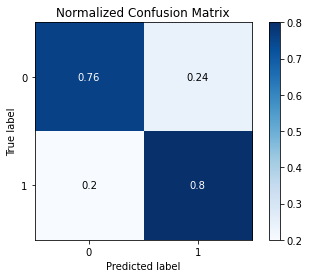

In [30]:
model_LR_F1(2, 'newton-cg')

0
1
2
3
4
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.813


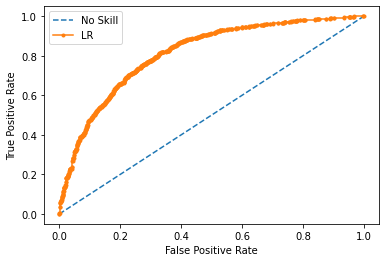

Average train F1 score: 0.833274696502528 +/- 0.0034813041071515803
Average test F1 score: 0.7378391001023227 +/- 0.007756316621305131
Total time: 5.732639789581299


(0.833274696502528,
 0.0034813041071515803,
 0.7378391001023227,
 0.007756316621305131,
 5.7336366176605225)

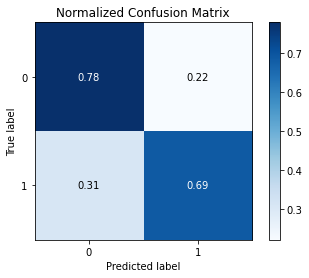

In [10]:
model_LR_F1(.01, 'lbfgs')

<module 'matplotlib.pyplot' from 'C:\\Users\\Juan José\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

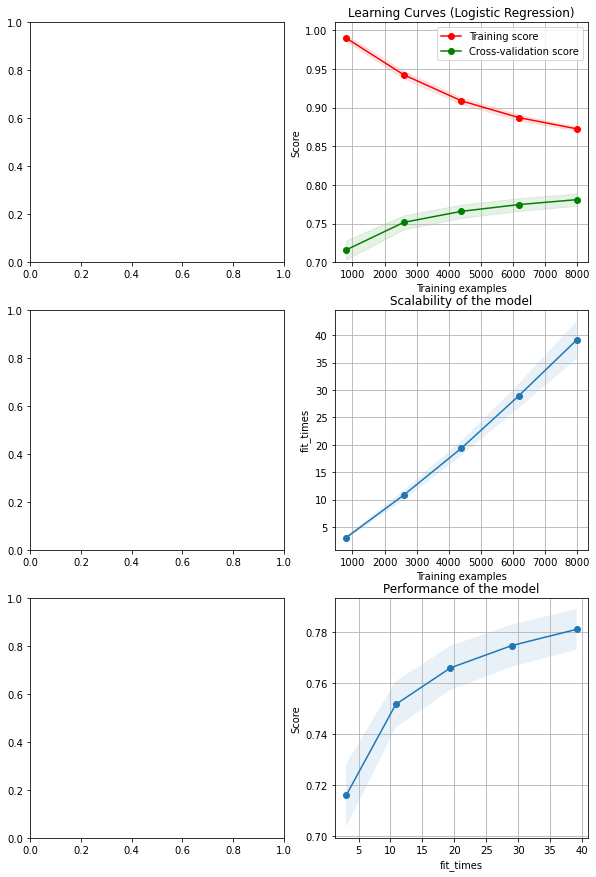

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

LR = LogisticRegression(C=2, solver='newton-cg', max_iter = 200)

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

title = "Learning Curves (Logistic Regression)"

plot_learning_curve(LR, title, X, Y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

### Reduced features

#### Chi2 - 100 features

In [13]:
X = loadHD5('FS_Chi2_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.799


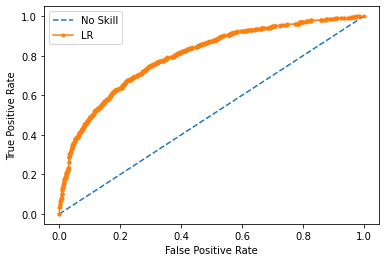

           Training score      +/-  Test score      +/-
f1                0.74321  0.00561     0.73581  0.00837
accuracy          0.74330  0.00269     0.73590  0.00674
precision         0.74366  0.00967     0.73621  0.01070
recall            0.74330  0.00269     0.73590  0.01938
Total time: 0.848822832107544


(0.743206064833718,
 0.005611704121616416,
 0.7358113585306393,
 0.008369125098101915,
 0.8498170375823975)

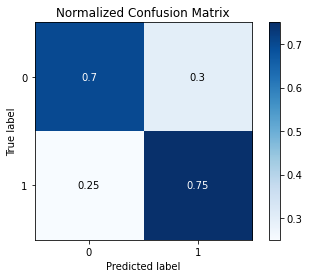

In [20]:
model_LR_F1(.01, 'lbfgs')

#### F-value - 100

In [21]:
X = loadHD5('FS_Fisher_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.810


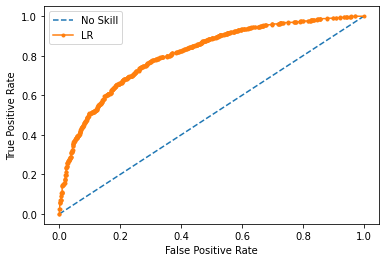

           Training score      +/-  Test score      +/-
f1                0.74691  0.00442     0.73726  0.00725
accuracy          0.74692  0.00381     0.73730  0.00639
precision         0.74700  0.00575     0.73746  0.00884
recall            0.74692  0.00381     0.73730  0.01444
Total time: 0.653841495513916


(0.7469055147451877,
 0.004417608609679877,
 0.7372557904174194,
 0.007254585639286156,
 0.653841495513916)

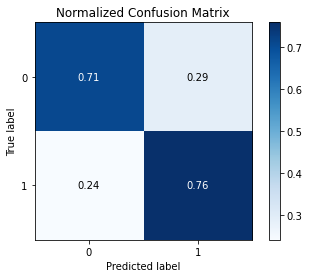

In [22]:
model_LR_F1(.01, 'lbfgs')

#### Mutual Information - 100

In [23]:
X = loadHD5('FS_Mutual_Information_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.721


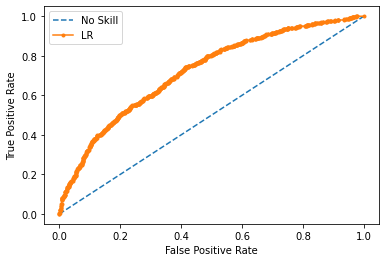

           Training score      +/-  Test score      +/-
f1                0.66954  0.00560     0.65444  0.00819
accuracy          0.66960  0.00319     0.65450  0.00691
precision         0.66973  0.00572     0.65461  0.00823
recall            0.66960  0.00319     0.65450  0.01493
Total time: 0.4921915531158447


(0.6695359090097507,
 0.005595955814647469,
 0.6544406229646125,
 0.008193148282957351,
 0.4921915531158447)

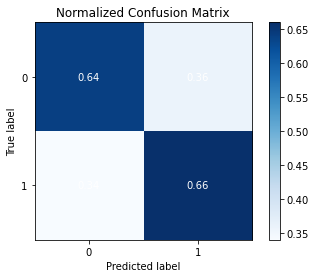

In [24]:
model_LR_F1(.01, 'lbfgs')

#### LDA

In [25]:
X = loadHD5('LDA_LSA_1500')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.932


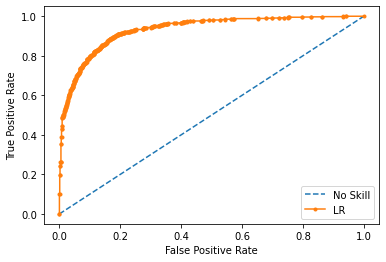

           Training score      +/-  Test score      +/-
f1                0.85277  0.00224     0.85269  0.00834
accuracy          0.85278  0.00207     0.85270  0.00823
precision         0.85282  0.00459     0.85283  0.01070
recall            0.85278  0.00207     0.85270  0.01262
Total time: 0.8285095691680908


(0.8527700119638035,
 0.0022438243649391815,
 0.85268670582263,
 0.008339586078744875,
 0.8285095691680908)

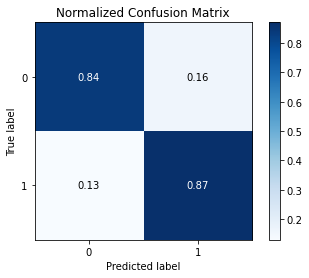

In [26]:
model_LR_F1(.01, 'lbfgs')

#### PCA - 700

In [27]:
X = loadHD5('PCA_LSA_1500_700')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.843


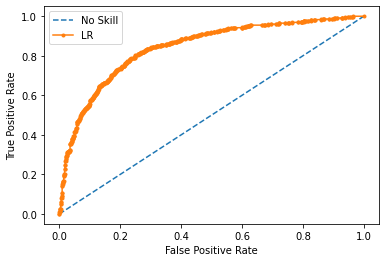

           Training score      +/-  Test score      +/-
f1                0.78712  0.00220     0.76778  0.00511
accuracy          0.78712  0.00204     0.76780  0.00473
precision         0.78714  0.00298     0.76788  0.00660
recall            0.78712  0.00204     0.76780  0.00970
Total time: 1.6829133033752441


(0.7871219559386207,
 0.002196416285895912,
 0.7677834453384116,
 0.005111555722262923,
 1.6829133033752441)

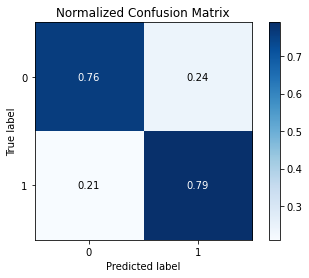

In [28]:
model_LR_F1(.01, 'lbfgs')

#### SFS (Wrapper) - 100

In [14]:
sfs = loadModel('SFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sfs.k_feature_idx_]

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.729


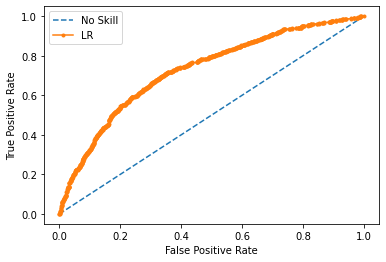

           Training score      +/-  Test score      +/-
f1                0.67475  0.02200     0.66727  0.02481
accuracy          0.67622  0.00152     0.66890  0.00805
precision         0.67949  0.02425     0.67224  0.02518
recall            0.67622  0.00152     0.66890  0.07032
Total time: 0.6023044586181641


(0.6747452307837846,
 0.021999341772475558,
 0.667268997049837,
 0.024814795387311395,
 0.6023044586181641)

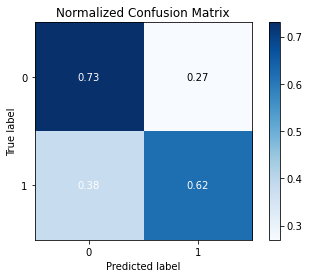

In [15]:
model_LR_F1(.01, 'lbfgs')

#### SFFS (Wrapper) - 100

In [16]:
sffs = loadModel('SFFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sffs.k_feature_idx_]

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GaussianNB from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.731


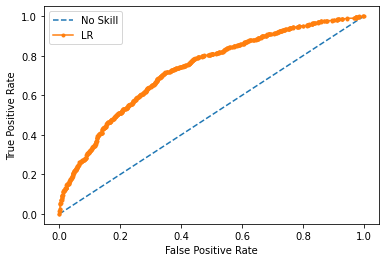

           Training score      +/-  Test score      +/-
f1                0.66363  0.02573     0.65796  0.02855
accuracy          0.66558  0.00304     0.66000  0.01126
precision         0.66949  0.02599     0.66397  0.02850
recall            0.66558  0.00304     0.66000  0.07815
Total time: 0.5491185188293457


(0.663632962624764,
 0.02572758805497706,
 0.6579642594971474,
 0.028545398473575175,
 0.5491185188293457)

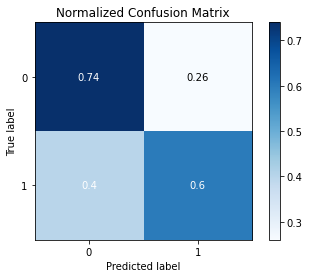

In [17]:
model_LR_F1(.01, 'lbfgs')

#### Pearson correlation coefficient - 101

In [18]:
X = loadHD5('PEARSON_LSA_1500_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.627


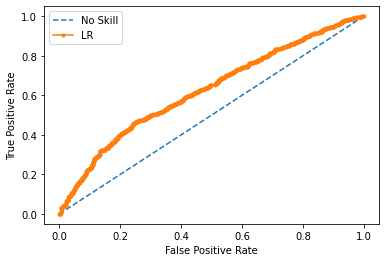

           Training score      +/-  Test score      +/-
f1                0.59434  0.00347     0.58535  0.00720
accuracy          0.59435  0.00270     0.58540  0.00544
precision         0.59436  0.00288     0.58544  0.00574
recall            0.59435  0.00270     0.58540  0.01248
Total time: 0.41649913787841797


(0.5943382941185582,
 0.0034723498789227918,
 0.5853474311194182,
 0.007200472366217352,
 0.41649913787841797)

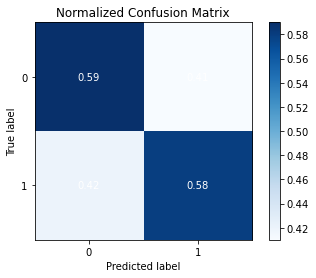

In [19]:
model_LR_F1(.01, 'lbfgs')